<a href="https://colab.research.google.com/github/Anwerzain/3D-Model-Generator-Project/blob/main/3D_Model_Generator_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------>
#                                         Step 1: Install all required packages with compatible versions
#<------------------------------------------------------------------------------------------------------------------------------------------------------>
!pip install numpy==1.23.5 opencv-python matplotlib rembg pyrender trimesh
#<------------------------------------------------------------------------------------------------------------------------------------------------------>

In [3]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------>
#                                                      Step 2: Import libraries
#<------------------------------------------------------------------------------------------------------------------------------------------------------>
import cv2
import numpy as np
from rembg import remove
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pyrender
import trimesh
from google.colab import files
import os
#<------------------------------------------------------------------------------------------------------------------------------------------------------>

In [4]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------>
#                                         Step 3: Image processing function (fixed file handling)
#<------------------------------------------------------------------------------------------------------------------------------------------------------>
def process_image(uploaded_file):
    # Handle both file objects and raw bytes
    if isinstance(uploaded_file, bytes):
        file_bytes = uploaded_file
    else:
        file_bytes = uploaded_file.read()

    # Convert to numpy array and decode image
    nparr = np.frombuffer(file_bytes, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    # Remove background
    img_removed_bg = remove(img)

    # Convert to grayscale
    gray = cv2.cvtColor(img_removed_bg, cv2.COLOR_BGR2GRAY)

    # Create depth map
    depth_map = cv2.Sobel(gray, cv2.CV_64F, 1, 1, ksize=5)
    depth_map = np.abs(depth_map)
    depth_map = depth_map / depth_map.max()

    # Create 3D point cloud
    height, width = gray.shape
    x = np.linspace(0, width-1, width)
    y = np.linspace(0, height-1, height)
    x, y = np.meshgrid(x, y)
    z = depth_map * 100  # Scale depth

    # Create mesh faces
    vertices = np.column_stack((x.flatten(), -y.flatten(), z.flatten()))
    faces = []
    for i in range(height-1):
        for j in range(width-1):
            v1 = i * width + j
            v2 = v1 + 1
            v3 = (i + 1) * width + j
            faces.append([v1, v2, v3])
            faces.append([v2, v3, (i+1)*width + (j+1)])

    # Save as OBJ file
    obj_filename = 'output.obj'
    with open(obj_filename, 'w') as f:
        for v in vertices:
            f.write(f"v {v[0]} {v[1]} {v[2]}\n")
        for face in faces:
            f.write(f"f {face[0]+1} {face[1]+1} {face[2]+1}\n")

    return obj_filename, vertices, np.array(faces)
#<------------------------------------------------------------------------------------------------------------------------------------------------------>

In [5]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------>
#                                                 Step 4: Text to 3D function
#<------------------------------------------------------------------------------------------------------------------------------------------------------>
def process_text(prompt):
    if "car" in prompt.lower():
        # Car shape
        vertices = np.array([
            [0,0,0], [2,0,0], [2,1,0], [0,1,0],  # Base
            [0.5,0,0.5], [1.5,0,0.5], [1.5,1,0.5], [0.5,1,0.5]  # Top
        ])
        faces = np.array([
            [0,1,2], [0,2,3],  # Bottom
            [4,5,6], [4,6,7],   # Top
            [0,1,5], [0,5,4],   # Front
            [2,3,7], [2,7,6],   # Back
            [1,2,6], [1,6,5],   # Right
            [0,3,7], [0,7,4]    # Left
        ])
    else:
        # Default cube
        vertices = np.array([
            [0,0,0], [1,0,0], [1,1,0], [0,1,0],
            [0,0,1], [1,0,1], [1,1,1], [0,1,1]
        ])
        faces = np.array([
            [0,1,2], [0,2,3],  # Bottom
            [4,5,6], [4,6,7],  # Top
            [0,1,5], [0,5,4],  # Front
            [2,3,7], [2,7,6],  # Back
            [1,2,6], [1,6,5],  # Right
            [0,3,7], [0,7,4]   # Left
        ])

    obj_filename = 'text_model.obj'
    with open(obj_filename, 'w') as f:
        for v in vertices:
            f.write(f"v {v[0]} {v[1]} {v[2]}\n")
        for face in faces:
            f.write(f"f {face[0]+1} {face[1]+1} {face[2]+1}\n")

    return obj_filename, vertices, faces
#<------------------------------------------------------------------------------------------------------------------------------------------------------>

In [6]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------>
#                                         Step 5: Visualization functions (fixed NumPy compatibility)
#<------------------------------------------------------------------------------------------------------------------------------------------------------>
def show_3d_plot(vertices, faces):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_trisurf(vertices[:,0], vertices[:,1], faces, vertices[:,2],
                   cmap='viridis', edgecolor='none')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('3D Model Visualization')
    plt.show()

def show_interactive_3d(obj_path):
    try:
        mesh = trimesh.load(obj_path)
        scene = pyrender.Scene()

        # Add mesh with basic material
        mesh = pyrender.Mesh.from_trimesh(mesh, material=None)
        scene.add(mesh)

        # Set up camera
        camera = pyrender.PerspectiveCamera(yfov=np.pi/3.0, aspectRatio=1.0)
        camera_pose = np.array([
            [1.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 3.0],
            [0.0, 0.0, 0.0, 1.0],
        ])
        scene.add(camera, pose=camera_pose)

        # Add light
        light = pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], intensity=3.0)
        scene.add(light, pose=camera_pose)

        # Show viewer
        pyrender.Viewer(scene, use_raymond_lighting=True)
    except Exception as e:
        print(f"Interactive 3D viewer failed: {str(e)}")
        print("Showing matplotlib visualization instead...")
        mesh = trimesh.load(obj_path)
        show_3d_plot(mesh.vertices, mesh.faces)
#<------------------------------------------------------------------------------------------------------------------------------------------------------>

1. Image to 3D Model
2. Text to 3D Model
Enter choice (1/2): 2
Enter text prompt (e.g., 'a small car'): a small car


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

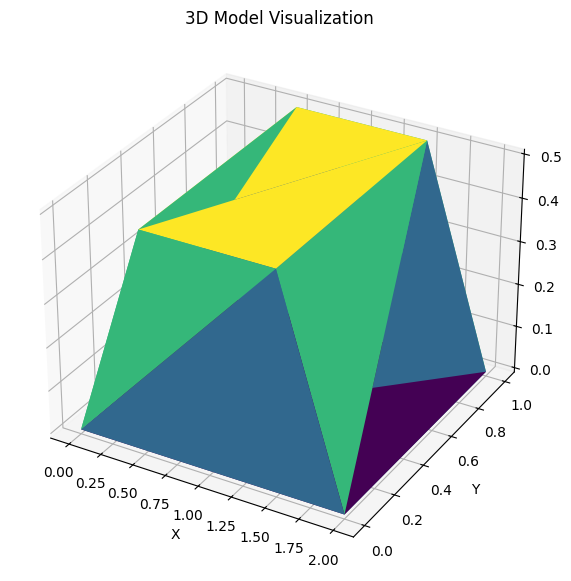

Interactive 3D viewer failed: Cannot connect to "None"
Showing matplotlib visualization instead...


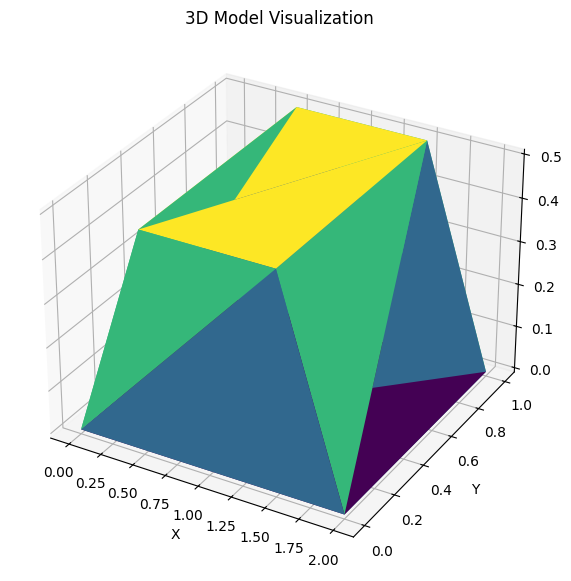

In [7]:
#<------------------------------------------------------------------------------------------------------------------------------------------------------>
#                                                            Step 6: Main program
#<------------------------------------------------------------------------------------------------------------------------------------------------------>
print("1. Image to 3D Model")
print("2. Text to 3D Model")
choice = input("Enter choice (1/2): ")

if choice == '1':
    print("Upload an image file (preferably simple object with clear edges)...")
    uploaded = files.upload()
    for filename in uploaded.keys():
        obj_file, vertices, faces = process_image(uploaded[filename])
        files.download(obj_file)
        show_3d_plot(vertices, faces)
        show_interactive_3d(obj_file)

elif choice == '2':
    prompt = input("Enter text prompt (e.g., 'a small car'): ")
    obj_file, vertices, faces = process_text(prompt)
    files.download(obj_file)
    show_3d_plot(vertices, faces)
    show_interactive_3d(obj_file)

else:
    print("Invalid choice")
#<------------------------------------------------------------------------------------------------------------------------------------------------------>